In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt

First, we copy and paste code from the Basic Planck Example.

generating new axis
['$\\mathrm{omega\\_b}$', '$\\mathrm{omega\\_cdm}$', '$\\mathrm{h}$', '$\\mathrm{A\\_s}$', '$\\mathrm{n\\_s}$', '$\\mathrm{tau\\_reio}$']


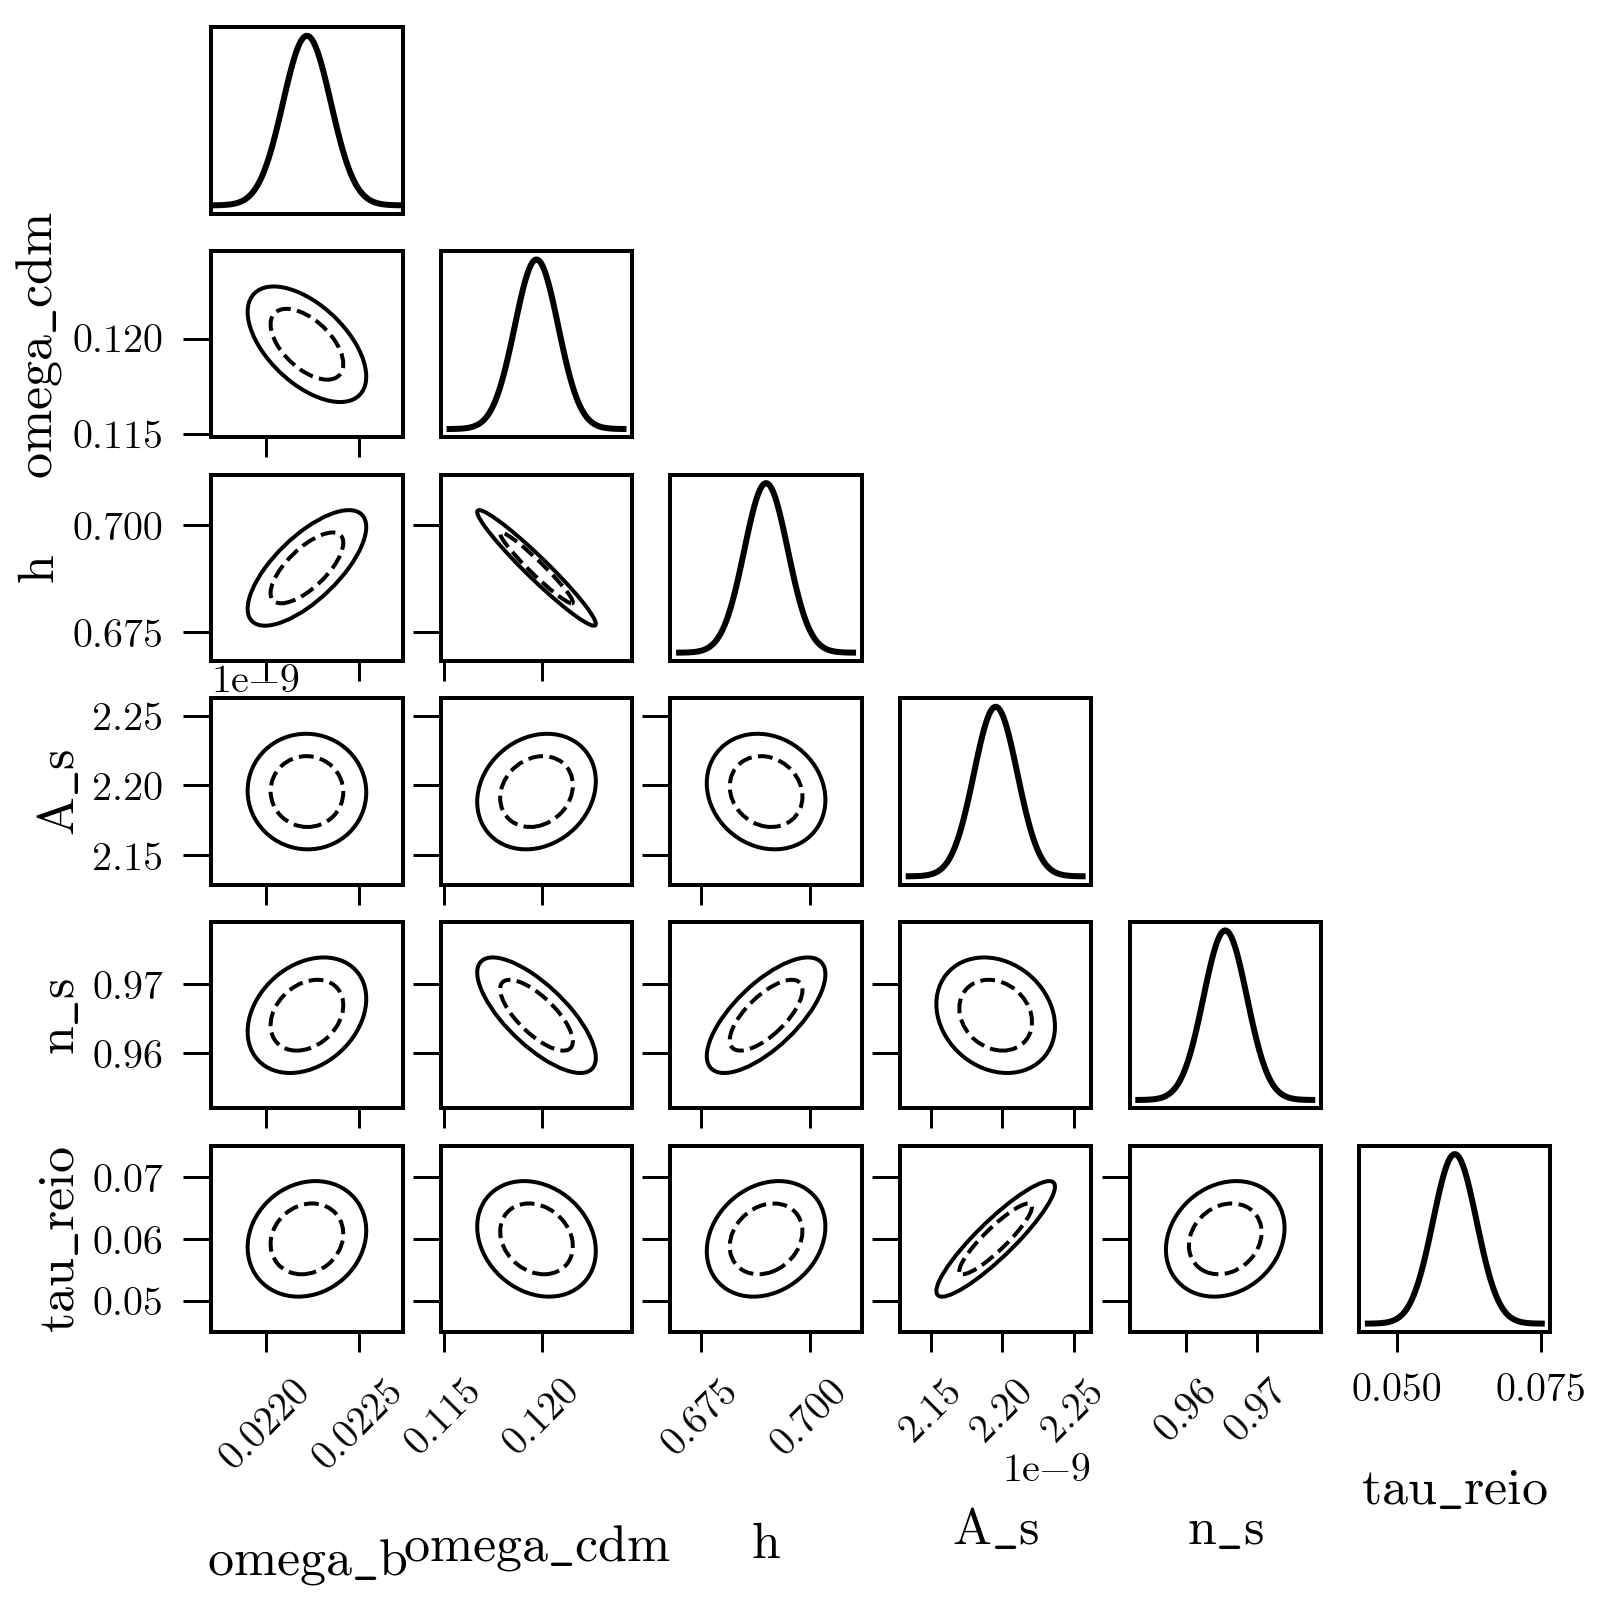

In [3]:
# create an Observables object to store information for derivatives

pars = np.array( ['omega_b', 'omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06])
steps = np.array([0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-steps,
                  right=centers+steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl',
                   'l_max_scalars': 2500,
                   'lensing': 'yes',
                   'non linear': 'halofit'}
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_CLASS_right', classy_dict=classy_right)
    
example_Planck = CMB_Primary(
    theta_fwhm=[7.], sigma_T=[33.], sigma_P=[56.],
    f_sky=0.65, l_min=2, l_max=2500)

fisher = example_Planck.get_fisher(obs)
cov = np.linalg.inv(fisher)
fishchips.util.plot_triangle(obs, cov);

# Arbitrary Priors

We use arbitrary priors by sampling and then plotting triangle plots with corner.py.

In [4]:
import corner

def unitize_cov(imp_cov, scales):
    imp_cov = imp_cov.copy()
    npar = imp_cov.shape[0]
    for i in range(npar):
        for j in range(npar):
            imp_cov[i,j] *= scales[i] * scales[j]
    return imp_cov

def get_samps(inp_cov, inp_means, num=int(1e8)):
    """
    Generate samples from a covariance matrix and input means.
    
    Parameters
    ----------
        inp_cov (2D numpy array) : covariance matrix from Fisher
        inp_means (1D numpy array) : mean values (mu), fiducial from Fisher
        
    Returns
    -------
        2D numpy array with each row corresponding to one random draw 
        from the multivariate Gaussian
    """
    samps = np.random.multivariate_normal( np.array(inp_means)/np.sqrt(np.diag(inp_cov)), 
                                           unitize_cov(inp_cov,1./np.sqrt(np.diag(inp_cov))), int(1e7))
    samps = samps[samps.T[-1]>0]
    for i in range(inp_cov.shape[0]):
        samps.T[i] *= np.sqrt(inp_cov[i,i])
        
    return samps


For example, we can just make the same plot we had just made, but this time with sampling.

In [5]:
unmodified_samples = get_samps(cov, centers)

In [23]:
unmodified_samples.shape

(10000000, 6)

/home/zequnl/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


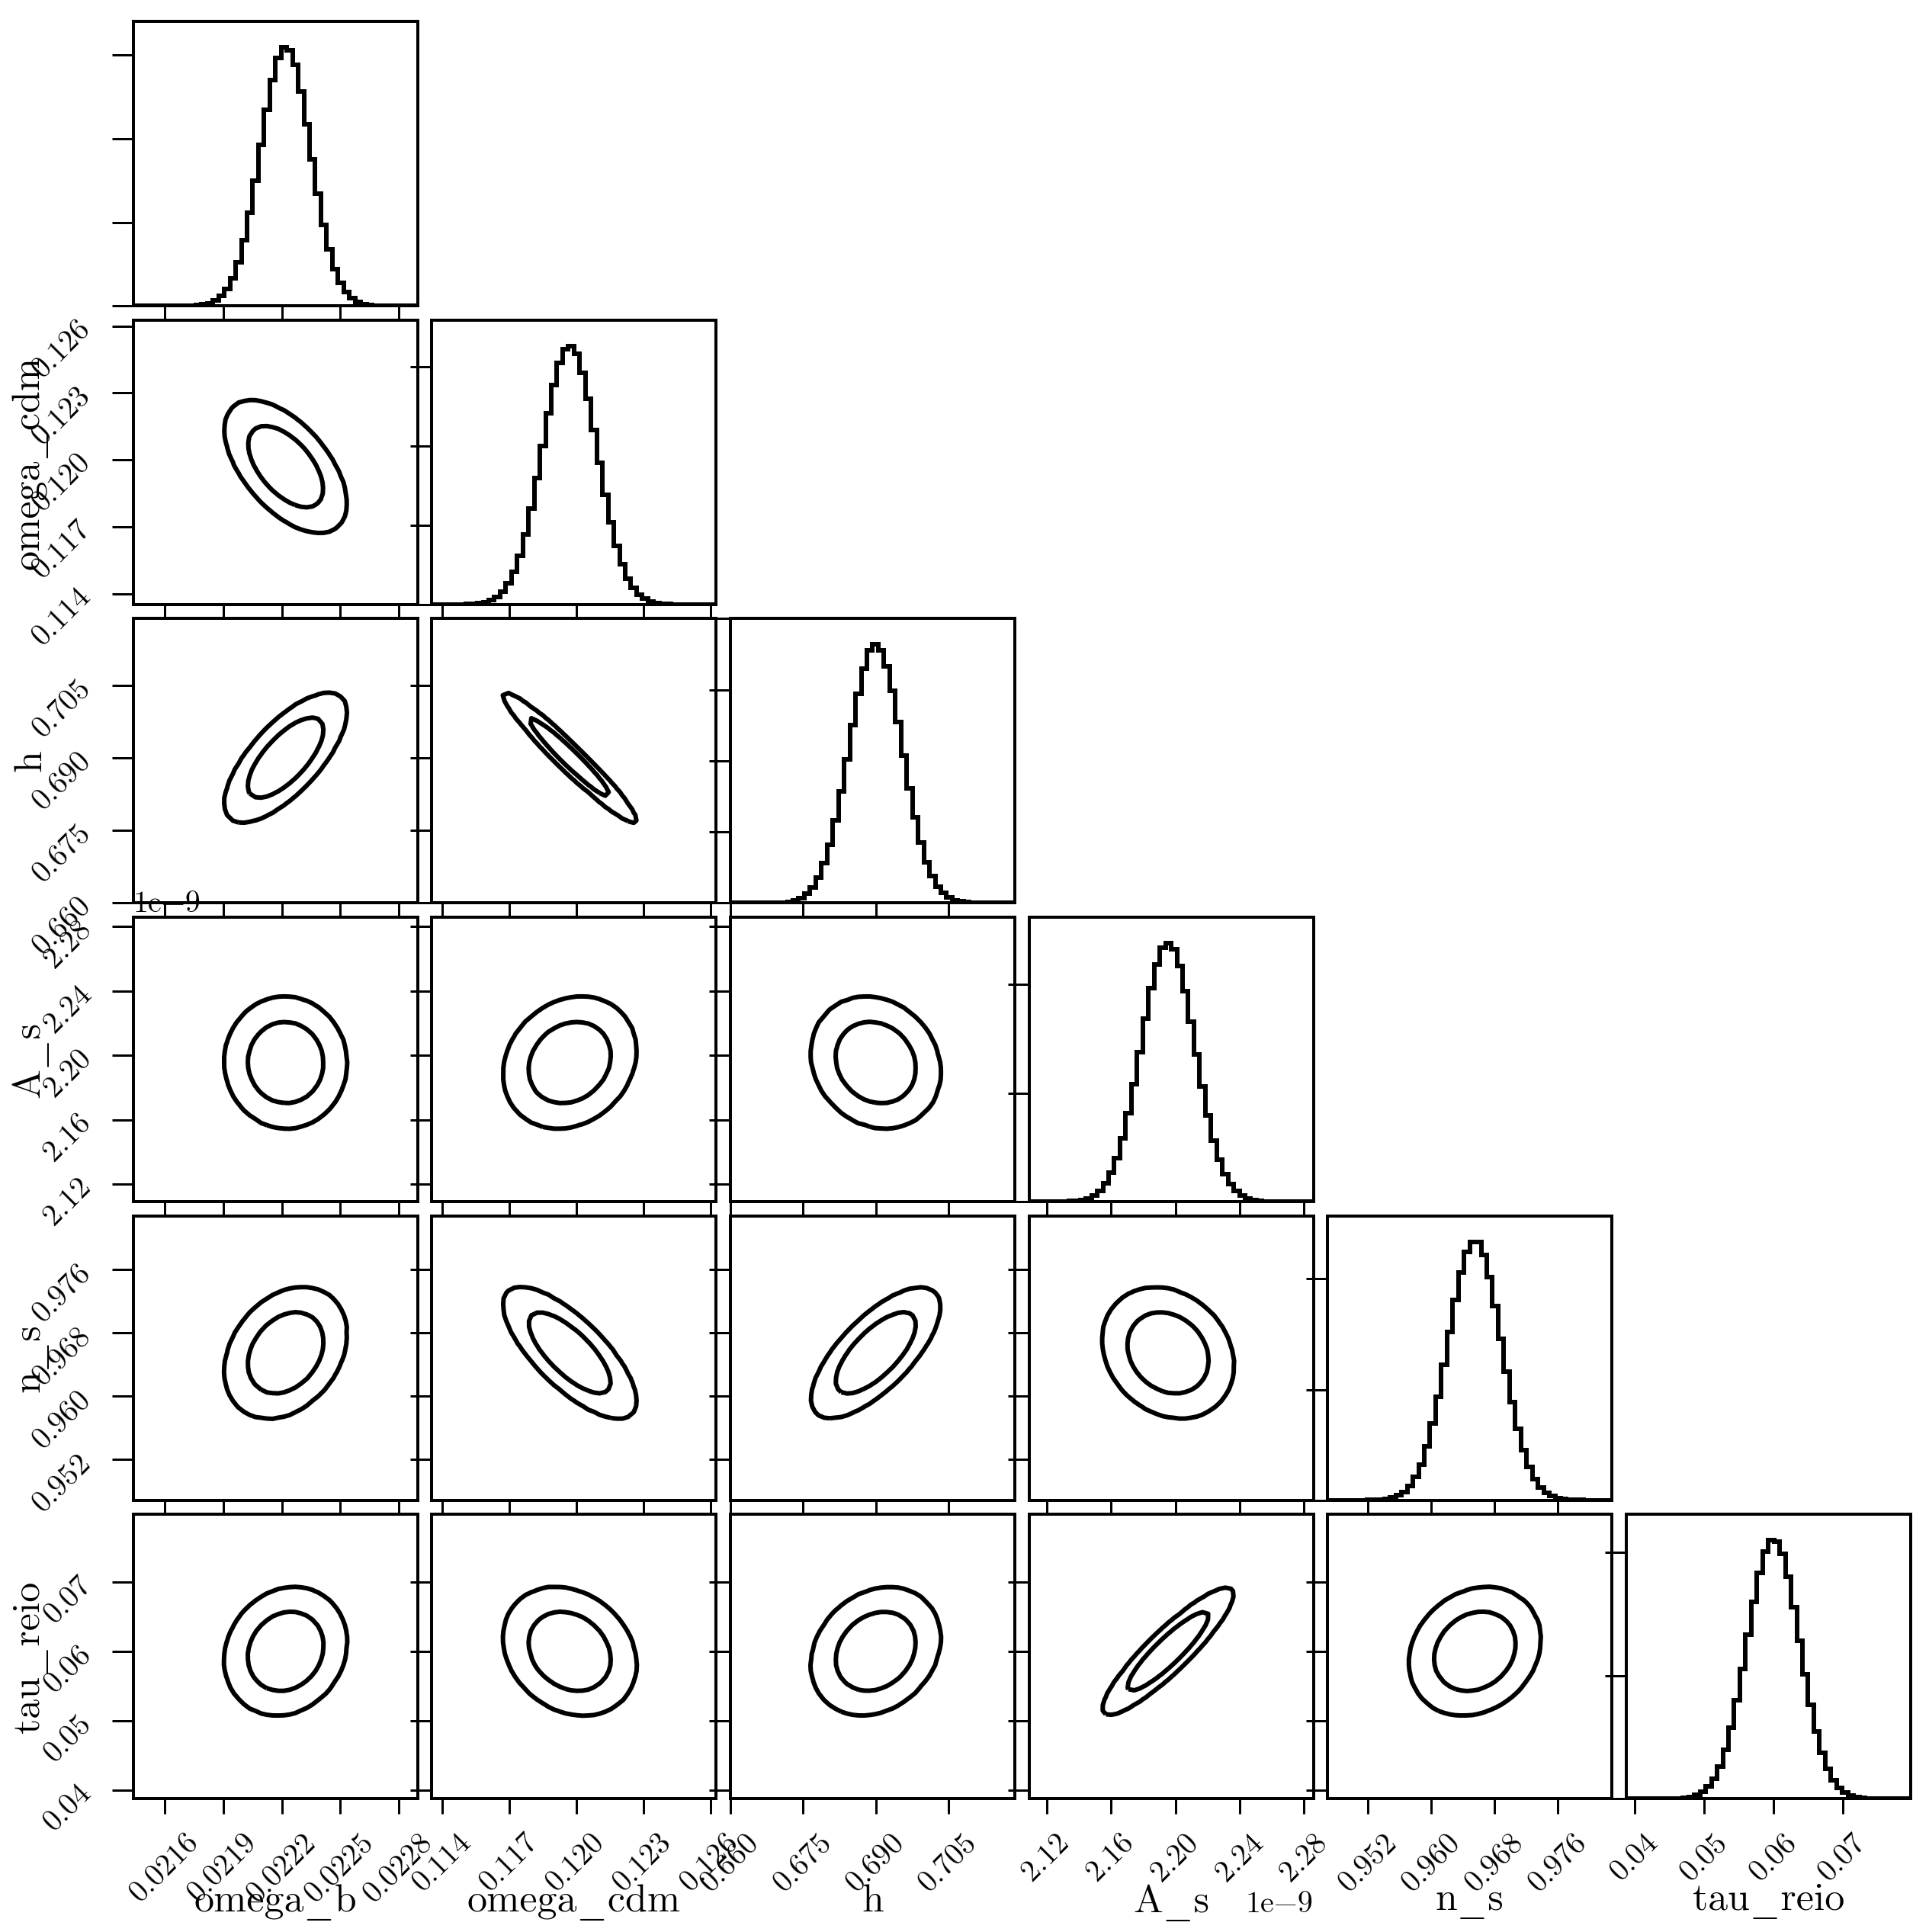

In [7]:
npar = cov.shape[0]
fig, ax = plt.subplots(npar, npar, figsize=(18,18))

corner.corner(unmodified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio']);

Now we can modify these samples. Let's change $\tau_{reio}$ into the parameter $\tau_{reio}^3$, and **also weight it by $\tau$**.

In [16]:
modified_samples = unmodified_samples.copy()
modified_samples.T[-1] = unmodified_samples.T[-1]**3 # change the last column (i.e. tau) 

In [20]:
modified_samples.T[-1]

array([0.00027948, 0.00021098, 0.00018474, ..., 0.00022799, 0.00024276,
       0.00022026])

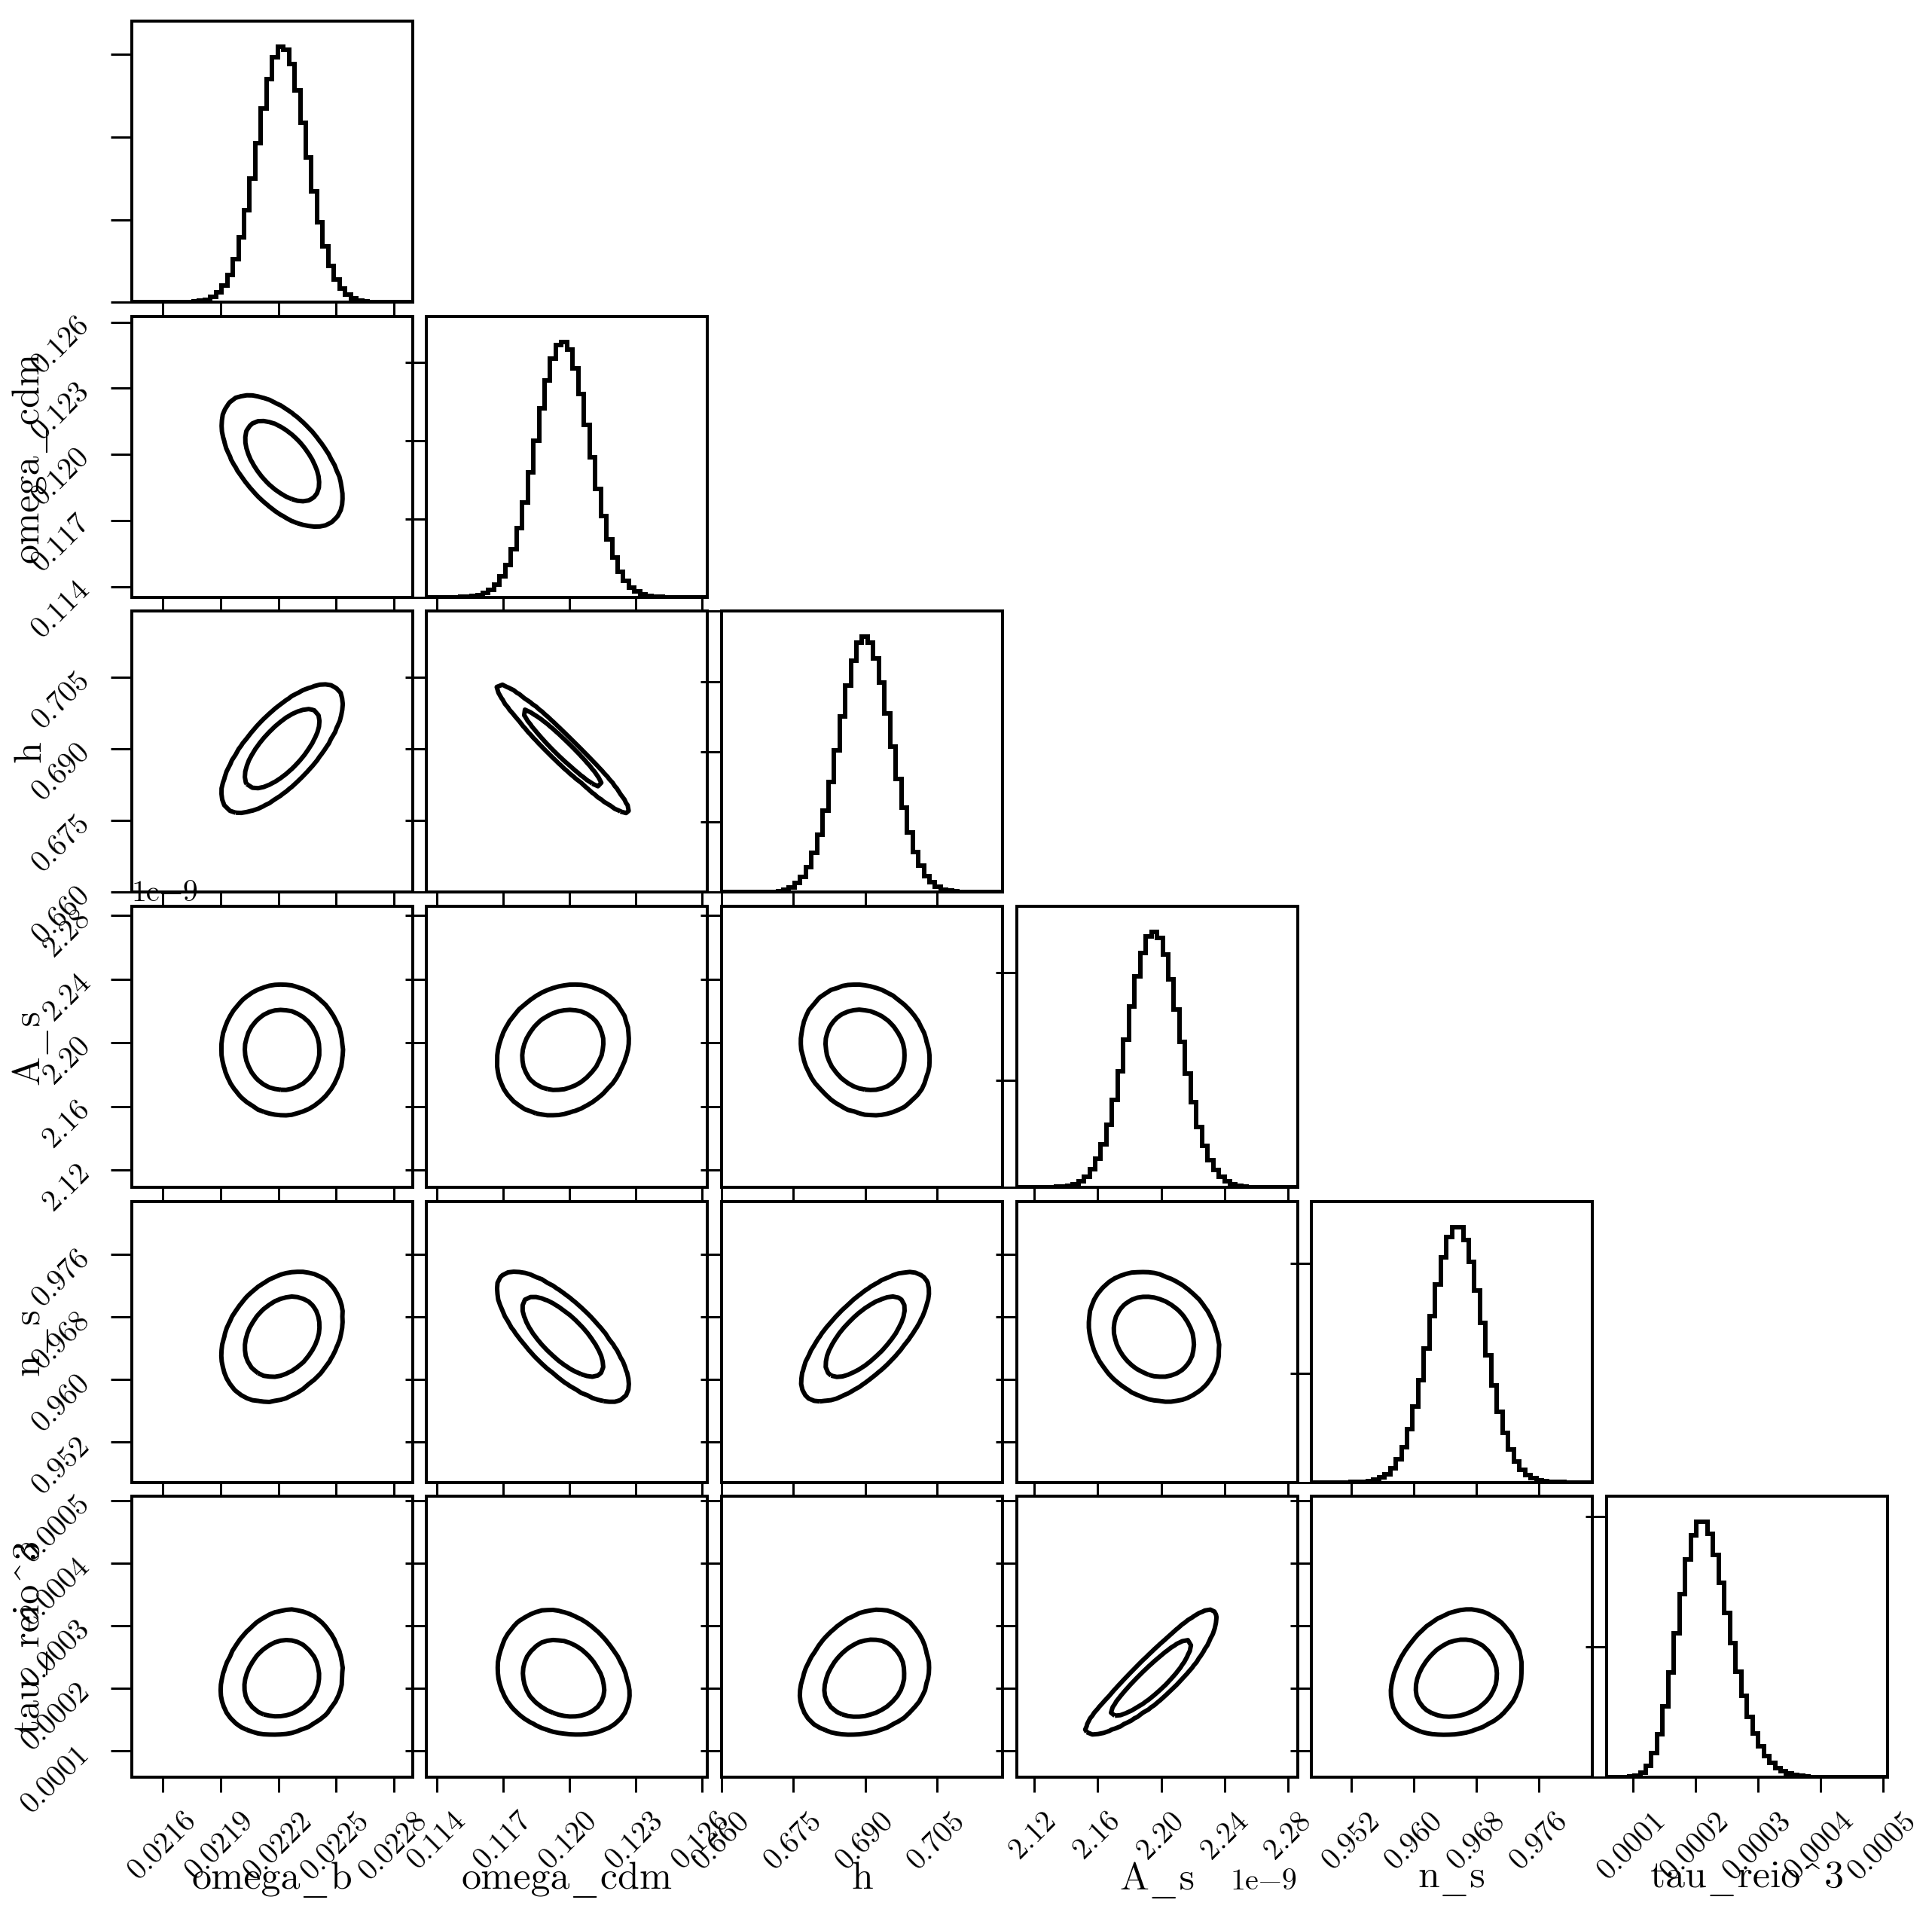

In [24]:
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio^3'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior

What if we disallow $h < 0.69$ as well?

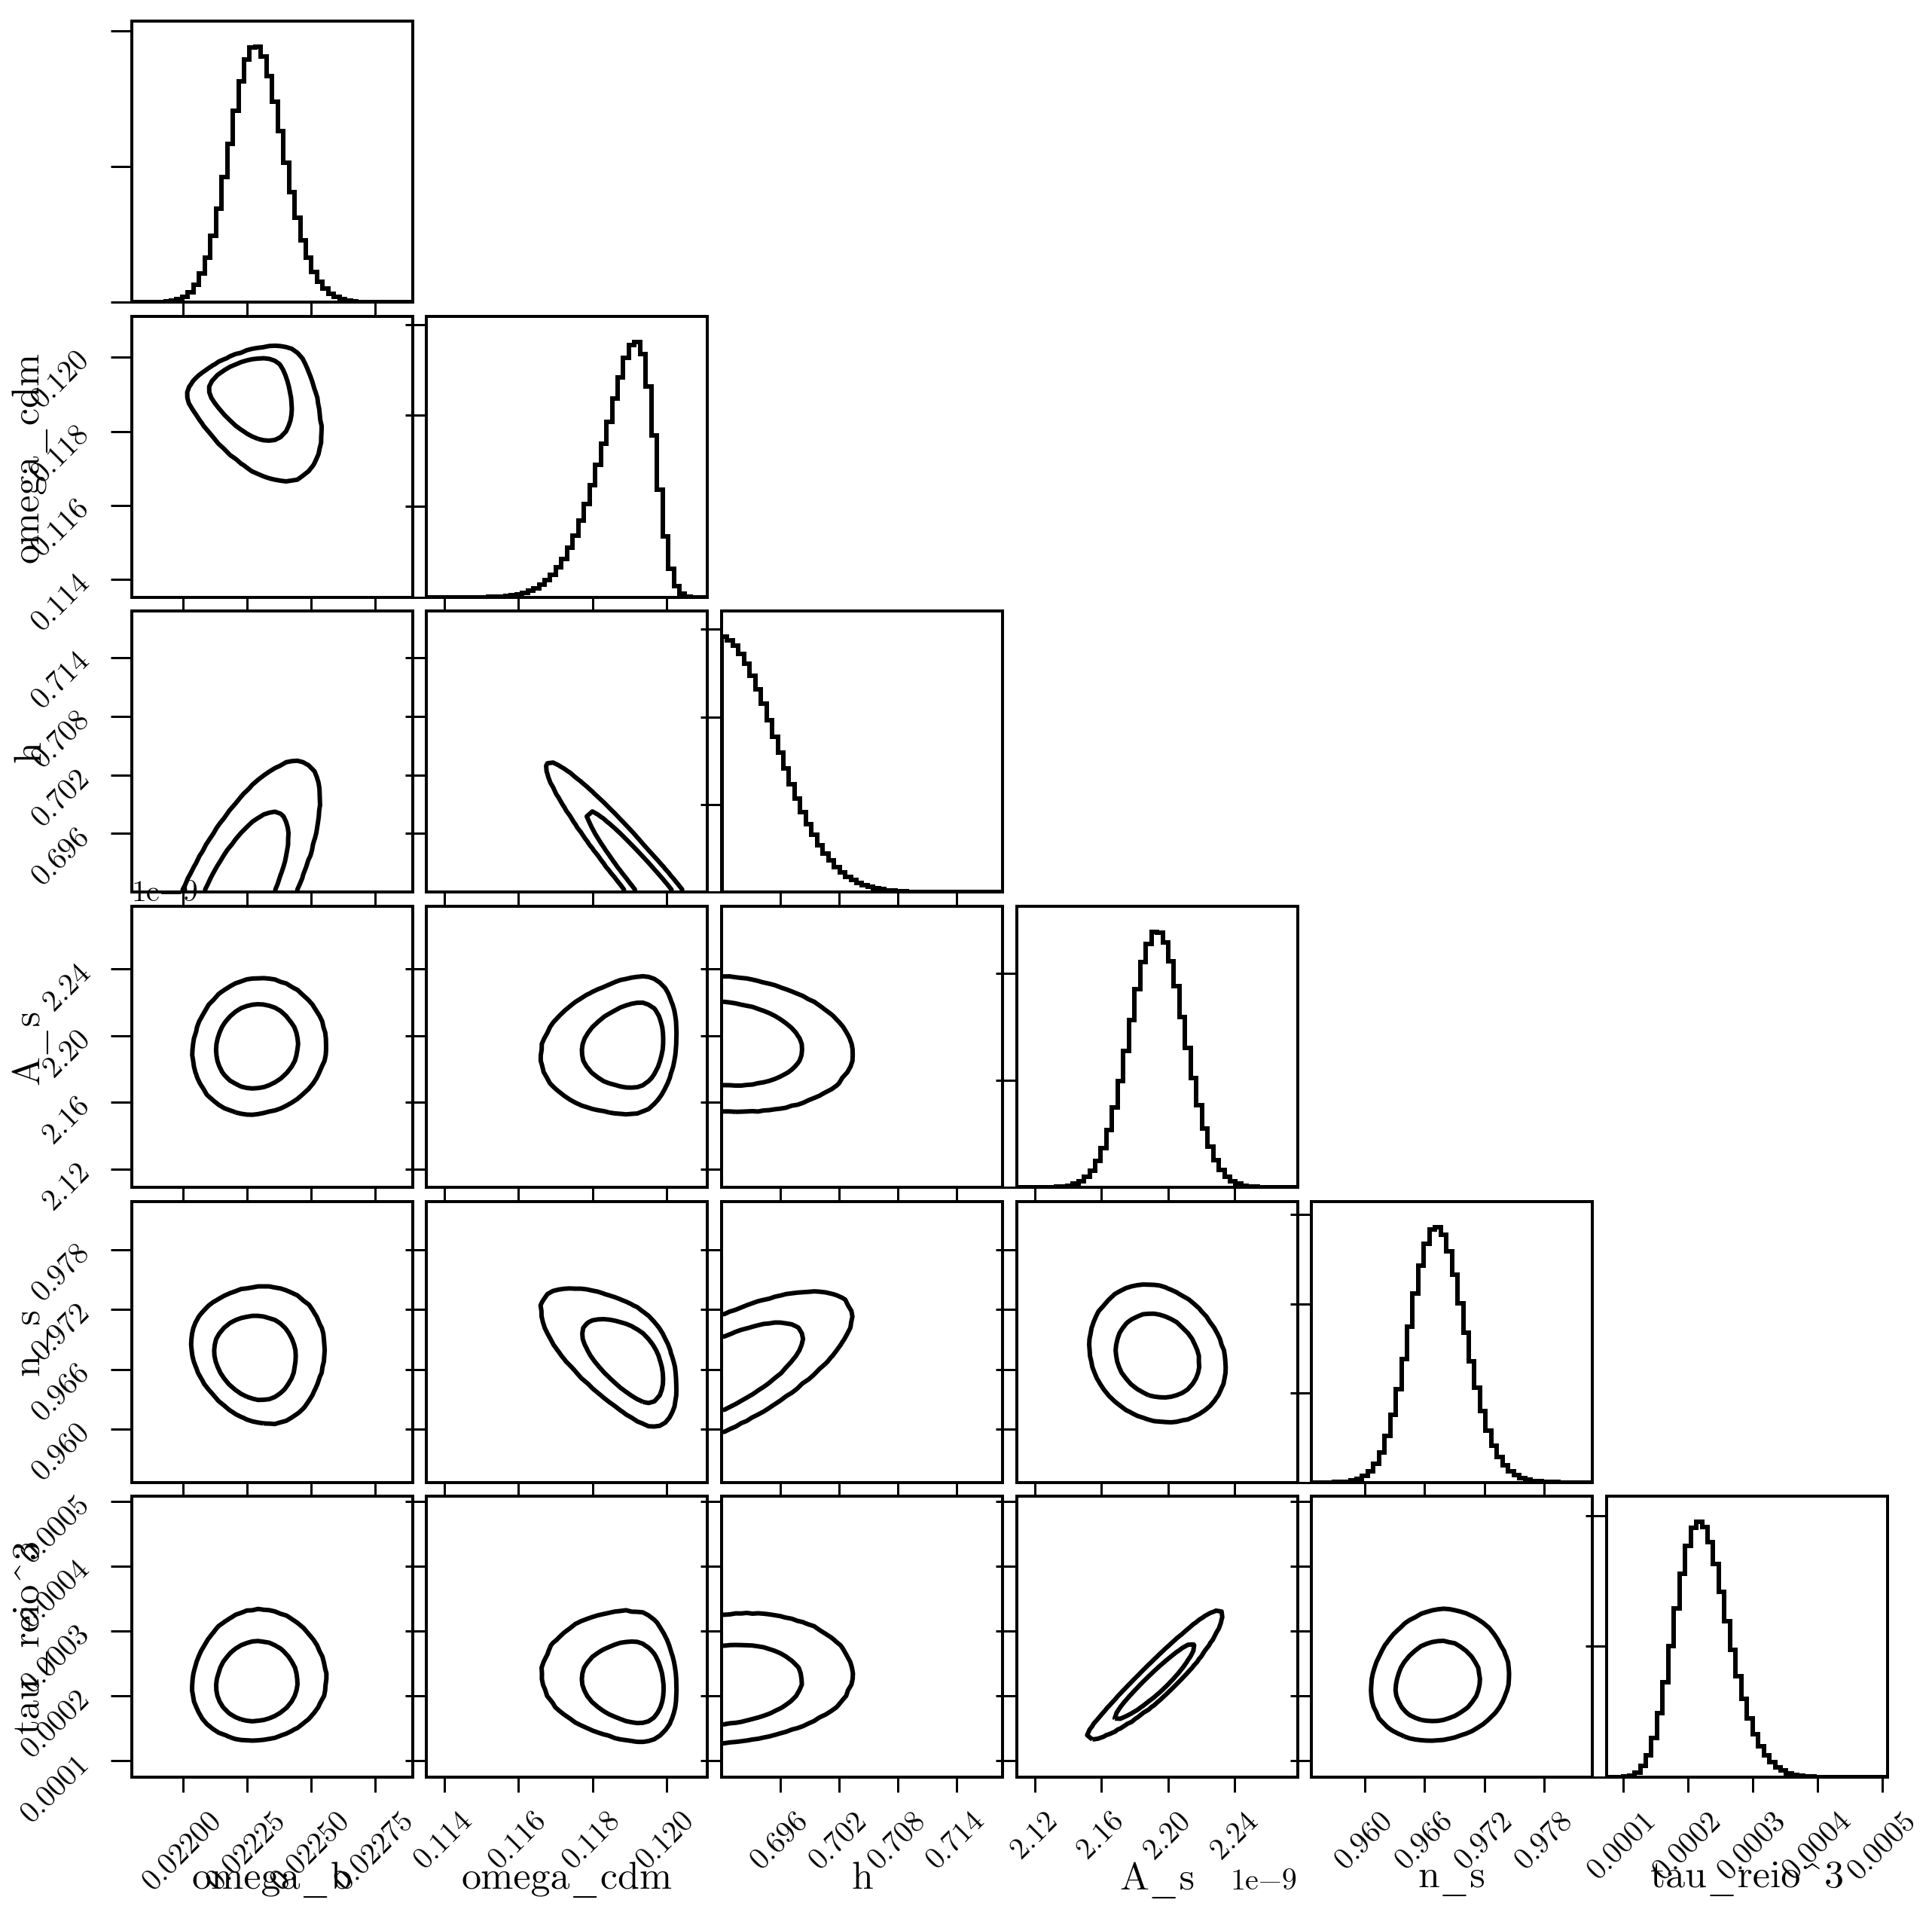

In [25]:
modified_samples = modified_samples[modified_samples.T[2]>0.69]

fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified_samples,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio^3'],
              
              weight=unmodified_samples.T[-1]); # the weight= allows for us to use a prior

Here are some possibly useful functions for your case!

In [22]:

def convert_to_cc_array(sig, mass_X):
    """utility function for converting sigma_p to the coupling constant
    
    Parameters
    ----------
        sig (float) : the cross section, sigma_p, possibly a numpy 
        mass_X (float) : dark matter particle mass in GeV
        
    Returns
    -------
        Numpy array that 
    """
    mp = 0.9382720813
    GeV = 1./(0.19732705e-15)
    cc_conversion = (1./( (246.22 * GeV)**4 * np.pi)) * \
        ( (mass_X * mp) / (mass_X + mp) * GeV )**2
    derived_cc = np.sqrt( sig / cc_conversion )
    return derived_cc


def get_95_exclusion(input_cov):
    """convenience function for turning a covariance matrix into a 95% exclusion.
    
    This function is specifically for the sigma_p case with a flat prior on the
    coupling, and positive definite cross section.
    
    Parameters
    ----------
        input_cov (numpy array) : covariance matrix
        
    Returns
    -------
        float, 95% upper limit for a fidcuial centered on zero
    """
    # NOTE: sigma_p MUST BE THE LAST VARIABLE
    samps = get_samps(input_cov, forecast_means_list, num=int(1e8))
    samps = samps[samps.T[-1]>0]
    onesig, twosig = corner.quantile(samps[:,-1], 
                                 [0.68,0.95], 
                                 weights=1./np.sqrt(samps.T[-1]))
    return twosig
    


You would run something like the following. (assuming that sigma_p is the last parameter in the list).


In [ ]:
samps = get_samps(cov, centers, num=int(1e8)) # get the samples from the covariance
samps = samps[samps.T[-1]>0] # sigma_p cannot be negative
modified = samps.copy()
modified.T[-1] = convert_to_cc_array(modified.T[-1], 1.0) * 1e-6 # convert to 1e6 * cc
    
fig, ax = plt.subplots(npar, npar, figsize=(18,18))
corner.corner(modified,
              plot_datapoints=False, plot_density=False, bins=50, 
              levels=(0.68,0.95), lw=2, fig=fig,
              hist_kwargs={'density':True}, labels=[r'omega_b', r'omega_cdm', r'h',  r'A_s', r'n_s', r'tau_reio', r'coupling'],
              
              weight=1./np.sqrt(samps.T[-1])); # sqrt(sigma_p) prior